# Práctica 3 - Ejercicio 2

Asignatura: Programación para la Inteligencia Artificial

Alumno: Laura Mondéjar Ruiz

Uno de los primeros modelos propuestos para la generación de datos usando Aprendizaje profundo fue el *Variational Autoencoder* (VAE).

Un VAE es una red autocodificadora que durante su entrenamiento, en lugar de codificar a un espacio latente de manera determinista (cada ejemplo tiene asociada una codificación), asocia distribuciones gaussianas que se muestrean para obtener una codificación que seguidamente se decodifica. Por tanto, el proceso queda como sigue:

$$\mu, \sigma^2 = e_{\theta_1}(x)$$

$$z \sim \mathcal{N}(\mu, \sigma^2) $$

$$y = d_{\theta_{2}} (z)$$

Para realizar el entrenamiento como cualquier red autocodificadora, se incluye una función de pérdida de reconstrucción:

$$L_{r}(x,y)$$

Pero además se añade una función de pérdida con el objetivo de regularizar las distribuciones gaussianas que pueden aprenderse. Para esto se usa la Divergencia de Kullback-Leibler, que mide el grado de disimilitud entre una distribución de probabilidad $Q$ respecto a una distribución de probabilidad $P$:

$$D_{KL}(P,Q) = \sum_{x \in X} P(x) log (\frac{P(x)}{Q(x)})$$

La divergencia KL se utiliza para penalizar que las distribuciones gaussianas se alejen de la distribución gaussiana de media 0 y varianza 1 ($\mathcal{N}(0, 1)$). Teniendo eso en cuenta, su formulación se puede simplificar a:

$$L_{KL}(\mu, \sigma)= \sum_{i=0}^n -\frac{1}{2}(1+log (\sigma_i^2) - \mu_i^2 - \sigma_i^2)$$

Siendo la función de pérdida que se usa durante el entrenamiento:

$$L = L_{r} + \alpha L_{KL}$$

con $\alpha$ un hiperparámetro que controla cuánto peso tiene la divergencia de Kullback-Leibler respecto a la pérdida de reconstrucción.

Tras implementar el VAE, se pide entrenarlo para los datos de  Fashion-MNIST con un espacio latente de 8 dimensiones (el vector $\mu$ y el que representa sus respectivas varianzas tienen 8 dimensiones cada uno). Una vez entrenado y comprobado debidamente que funciona, se pide mostrar las componentes del vector $\mu$ del conjunto de test en el espacio latente usando gráficas bidimensionales que indican la clase de cada ejemplo como en el Ejercicio 1.

Después, se debe extraer el vector prototípico para cada clase en el conjunto de test (la media de los vectores $\mu$ para cada clase) y mostrar las imágenes generadas por el decodificador a partir de las codificaciones interpoladas entre los vectores prototípicos de dos clases cualesquiera.

El cuaderno entregado debe llamarse ApellidosNombrePractica3Ejercicio2.ipynb

Notas:
 * Para realizar el muestreo $z$ permitiendo la retropropagación del error se usa el "truco de reparametrización": no muestrear directamente la distribución gaussiana obtenida (eso rompería el grafo de cómputo), sino la distribución gaussiana $\hat{z} \sim \mathcal{N}(0, 1)$ y aprovechar la propiedad de las gaussianas para convertir el muestreo de una distribución gaussiana en el de otra para que (una vez simplificado aprovechando que se muestrea la normal) quede  $z =  \hat{z} \sigma + \mu$.
 * Es más fácil (y equivalente) que el encoder genere el logaritmo de la varianza en lugar de la varianza. Así se evita la posibilidad de intentar computar un $log(0)$. Obviamente hay que ajustar las fórmulas que se implementan de manera acorde.
 * Aunque PyTorch implementa diversas funciones para calcular la divergencia KL, ninguna está directamente pensada para este uso y su aplicación no es directa, así que es más fácil simplemente implementarla. Hay que recordar usar los operadores de PyTorch para que se genere el grafo de cómputo sin problema y que la pérdida de un lote debe ser la media de las pérdidas de los ejemplos que lo forman.
 * El valor $\alpha$ para conseguir un entrenamiento apropiado puede ser muy bajo según el conjunto de datos al que se aplique (incluso menos de 0.01).

In [25]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
device_gpu = torch.device("cuda")

In [26]:
from google.colab import drive
drive.mount('/content/drive')
ruta = '/content/drive/MyDrive/PIA/fachionMNIST'

train_dataset = datasets.FashionMNIST( root=ruta, train=True, download=True, transform=transforms.ToTensor())
test_dataset = datasets.FashionMNIST(root=ruta, train=False, download=True, transform=transforms.ToTensor())

def split_dataset(dataset, split_share=0.5):
  """
  Devuelve dos subconjuntos del dataset. split_share define cuántos ejemplos irán al
  primer subconjunto. El resto irán al segundo.
  """
  mask_indices_to_first_subset = torch.rand(len(dataset))<=split_share
  indices_first_subset = [i for i, _ in enumerate(dataset) if mask_indices_to_first_subset[i]]
  indices_second_subset = [i for i, _ in enumerate(dataset) if not mask_indices_to_first_subset[i]]

  first_subset = torch.utils.data.Subset(dataset, indices_first_subset)
  second_subset = torch.utils.data.Subset(dataset, indices_second_subset)

  return first_subset, second_subset


train_dataset, val_dataset = split_dataset(train_dataset, split_share=0.8)
print(f"Número de ejemplos en entrenamiento: {len(train_dataset)}")
print(f"Número de ejemplos en validación: {len(val_dataset)}")
print(f"Número de ejemplos en test: {len(test_dataset)}")


def preload_data_to_tensors(dataloader):
    img, label = [], []
    for x, y in dataloader:
        img.append(x)
        label.append(y)
    X = torch.cat(img)
    Y = torch.cat(label)
    return X, Y


#Parametros
batch_size = 1024
learning_rate = 1e-3
epochs = 200
optimizer = torch.optim.Adam
validation_freq = 1
alpha = 0.01

train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size, shuffle=False)

#Precargar datos
train_img, train_labels = preload_data_to_tensors(train_dataloader)
val_img, val_labels = preload_data_to_tensors(val_dataloader)
test_img, test_labels = preload_data_to_tensors(test_dataloader)

train_dataset = torch.utils.data.TensorDataset(train_img.to(device_gpu), train_labels.to(device_gpu))
val_dataset = torch.utils.data.TensorDataset(val_img.to(device_gpu), val_labels.to(device_gpu))
test_dataset = torch.utils.data.TensorDataset(test_img.to(device_gpu), test_labels.to(device_gpu))

train_dataloader= DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Número de ejemplos en entrenamiento: 47990
Número de ejemplos en validación: 12010
Número de ejemplos en test: 10000


In [27]:
class VAE(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super().__init__()

        #ENCODER
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dim, 400),
            nn.ReLU()
        )

        #capas especiales
        self.capa_mu = nn.Linear(400, latent_dim)
        self.capa_var = nn.Linear(400, latent_dim)

        #DECODER
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 400),
            nn.ReLU(),
            nn.Linear(400, input_dim),
            nn.Sigmoid() # Importante para que salga entre 0 y 1
        )

    def encode(self, x): #entra la imagen y sacamos las estadisticas
        h1 = self.encoder(x)
        #Usamos lo que aprendió h1 para calcular la media y la varianza.
        mu = self.capa_mu(h1)
        log_var = self.capa_var(h1)
        return mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5*log_var) #raiz de e^var -> e^exp*0.5
        z = torch.randn_like(std) #randn genera mumeros aleatorios que siguen una distribucion gaussiana con media 0 y dt 1.
        return mu + z*std

    def decode(self, z):
        return self.decoder(z)


    def forward(self, x): #conecta todo lo anterior
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)

        return self.decode(z), mu, log_var


In [28]:
def funcion_perdida(reconstructed_x, x, mu, log_var, alpha):
    x = x.view(-1, 784) #Aplanamos la imagen original para que coincida con la reconstruida

    mse_loss = torch.nn.functional.mse_loss(reconstructed_x, x)
    LKD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp(), dim= 1).mean()

    return mse_loss + alpha * LKD

In [29]:
#Bucle entrenamiento
def learning_loop(train_dataloader, val_dataloader, model, epochs, learning_rate, optimizer, validation_freq, device, alpha):
  epoch_loss_list = []
  val_loss_list = []

  model = model.to(device)

  opt = optimizer(
    model.parameters(),
    lr=learning_rate
  )

  with tqdm(range(epochs), desc="epoch:") as pbar:
    for epoch in pbar:
      # Entrenamiento
      steps_loss_list = []
      for img, _ in train_dataloader:
        #Mover los datos al dispositivo
        img = img.to(device)

        reconstruida, mu, var = model(img)                  # Forward
        opt.zero_grad()
        loss = funcion_perdida(reconstruida, img, mu, var, alpha)
        loss.backward()                                     # Backward
        steps_loss_list.append(loss.clone().detach())
        opt.step()

      train_loss = torch.tensor(steps_loss_list).mean()
      epoch_loss_list.append(train_loss)
      pbar.set_postfix(loss=f"{train_loss}")

      #Validación
      if epoch%validation_freq==0:
        val_step_loss_list = []

        with torch.no_grad():
          for img, _ in val_dataloader:

            # Mover los datos al dispositivo
            img = img.to(device)

            reconstruido, mu, var = model(img)

            loss_val = funcion_perdida(reconstruido, img, mu, var, alpha)
            val_step_loss_list.append(loss_val)

          val_loss = torch.tensor(val_step_loss_list).mean()
          val_loss_list.append(val_loss)

          #Actualizar barra de progreso
          pbar.set_postfix(train_loss=f"{train_loss:.4f}", val_loss=f"{val_loss:.4f}")

  return model, epoch_loss_list, val_loss_list

epoch:: 100%|██████████| 200/200 [02:14<00:00,  1.49it/s, train_loss=0.0625, val_loss=0.0624]


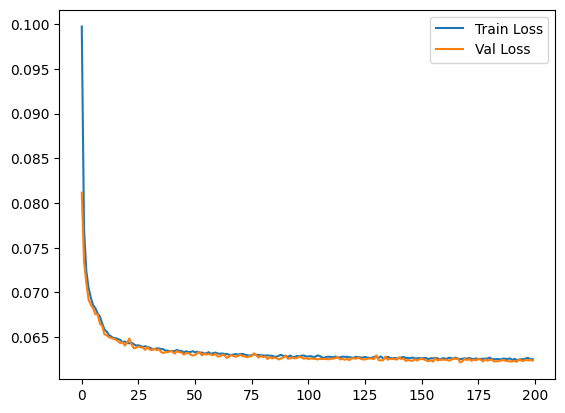

In [30]:
#ENTRENAMIENTO Y VALIDACIÓN
input_dim = 784 # 28x28 píxeles
latent_dim = 8
model = VAE(input_dim, latent_dim).to(device_gpu)

model, train_loss, val_loss= learning_loop(
    train_dataloader,
    val_dataloader,
    model,
    epochs,
    learning_rate,
    optimizer,
    validation_freq = validation_freq, device= device_gpu, alpha = alpha)

#Grafica errores
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Val Loss')
plt.legend()
plt.show()

Error Medio en Test: 0.0625


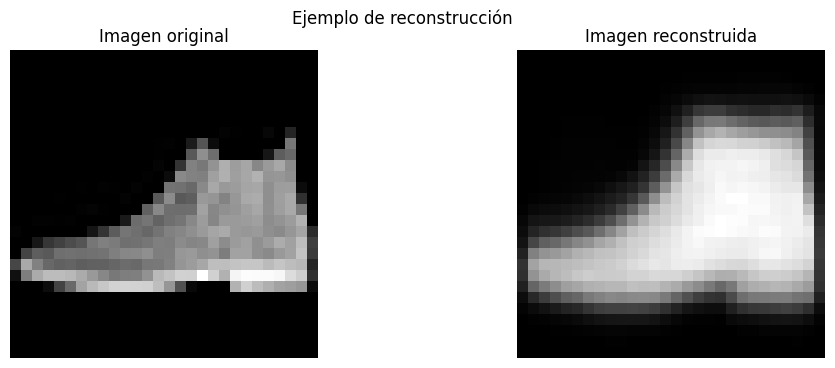

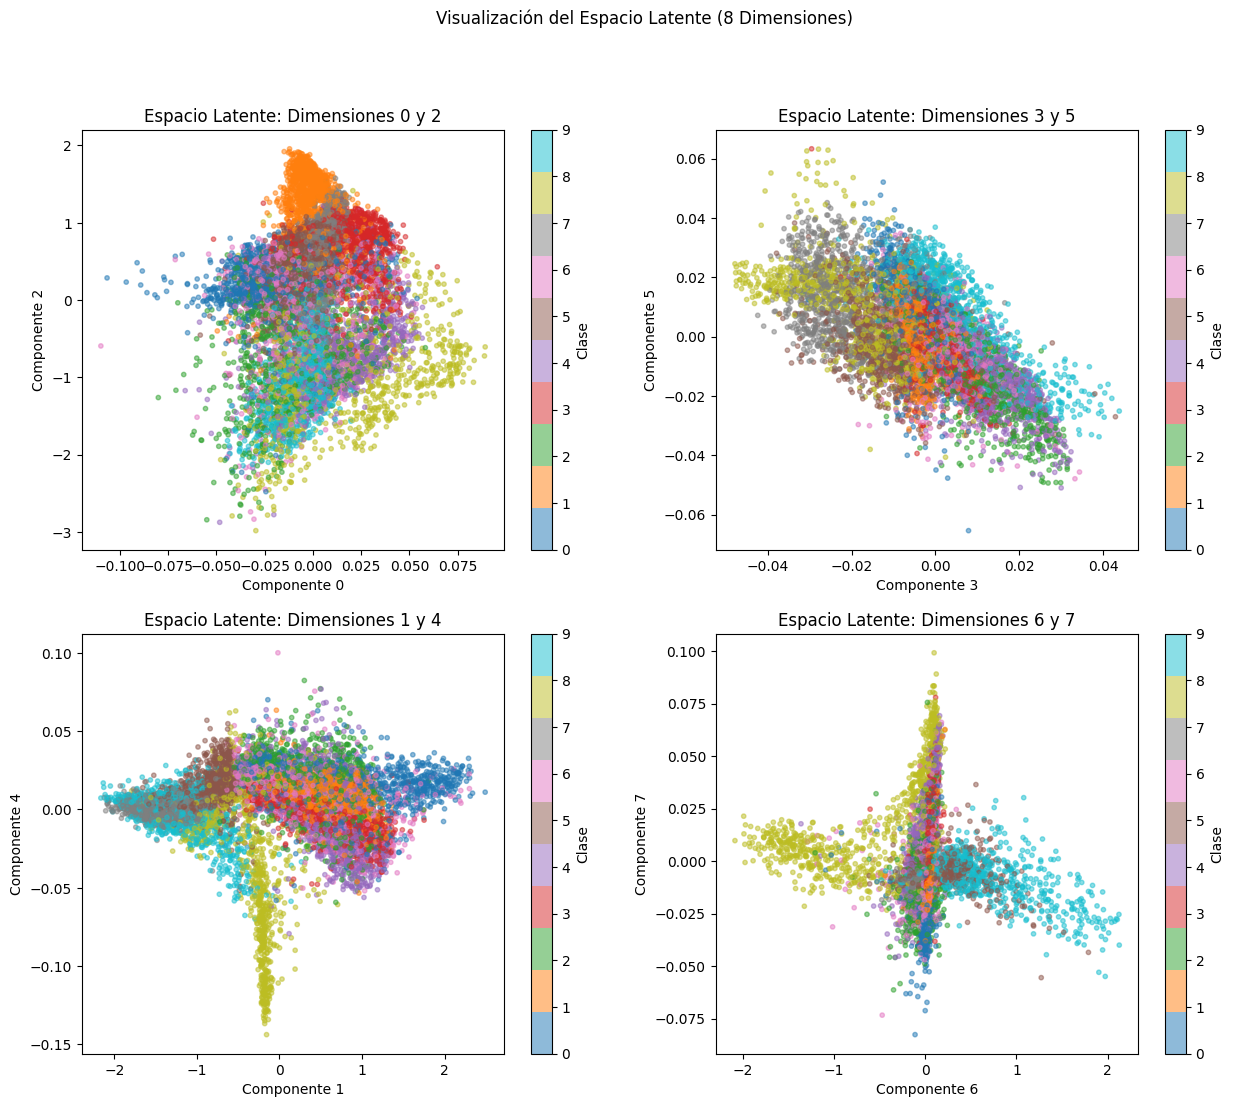

In [31]:
#TEST
total_mu = []
total_labels = []
total_loss = 0.0

example_data = None

with torch.no_grad():
  for img, labels in test_dataloader:
      img = img.to(device_gpu)

      rec, mu, var = model(img)

      loss = funcion_perdida(rec, img, mu, var, alpha)
      total_loss += loss.item()

      total_mu.append(mu.cpu())
      total_labels.append(labels.cpu())

      if example_data is None:
          example_data = (img.cpu(), rec.cpu())

error = total_loss / len(test_dataloader)
print(f"Error Medio en Test: {error:.4f}")

total_mu = torch.cat(total_mu)
total_labels = torch.cat(total_labels)

#imagen reconstruida
img, rec = example_data
idx = 0
img = img[idx].view(28, 28)
rec = rec[idx].view(28, 28)

plt.figure(figsize=(12, 4))
plt.suptitle("Ejemplo de reconstrucción")


#imagen original
plt.subplot(1, 2, 1)
plt.title("Imagen original")
plt.imshow(img, cmap='gray')
plt.axis('off')

#imagen reconstruida
plt.subplot(1, 2, 2)
plt.title("Imagen reconstruida")
plt.imshow(rec, cmap='gray')
plt.axis('off')



#graficas espacios latentes

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle("Visualización del Espacio Latente (8 Dimensiones)")
axes = axes.flatten()

scatter1 = axes[0].scatter(total_mu[:, 0], total_mu[:, 2], c=total_labels, cmap='tab10', alpha=0.5, s=10)
axes[0].set_title('Espacio Latente: Dimensiones 0 y 2')
axes[0].set_xlabel('Componente 0')
axes[0].set_ylabel('Componente 2')
plt.colorbar(scatter1, ax=axes[0], label='Clase')

scatter2 = axes[1].scatter(total_mu[:, 3], total_mu[:, 5], c=total_labels, cmap='tab10', alpha=0.5, s=10)
axes[1].set_title('Espacio Latente: Dimensiones 3 y 5')
axes[1].set_xlabel('Componente 3')
axes[1].set_ylabel('Componente 5')
plt.colorbar(scatter2, ax=axes[1], label='Clase')

scatter3 = axes[2].scatter(total_mu[:, 1], total_mu[:, 4], c=total_labels, cmap='tab10', alpha=0.5, s=10)
axes[2].set_title('Espacio Latente: Dimensiones 1 y 4')
axes[2].set_xlabel('Componente 1')
axes[2].set_ylabel('Componente 4')
plt.colorbar(scatter3, ax=axes[2], label='Clase')

scatter4 = axes[3].scatter(total_mu[:, 6], total_mu[:, 7], c=total_labels, cmap='tab10', alpha=0.5, s=10)
axes[3].set_title('Espacio Latente: Dimensiones 6 y 7')
axes[3].set_xlabel('Componente 6')
axes[3].set_ylabel('Componente 7')
plt.colorbar(scatter4, ax=axes[3], label='Clase')

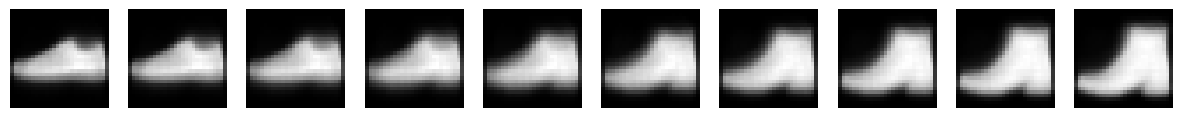

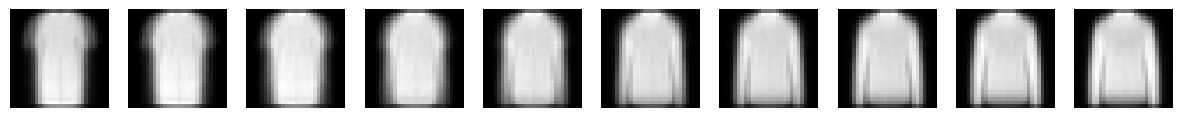

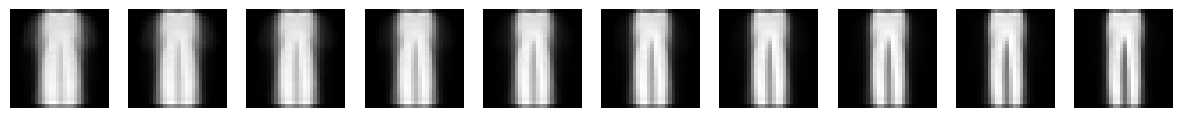

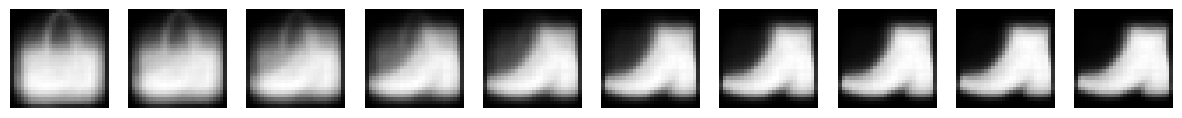

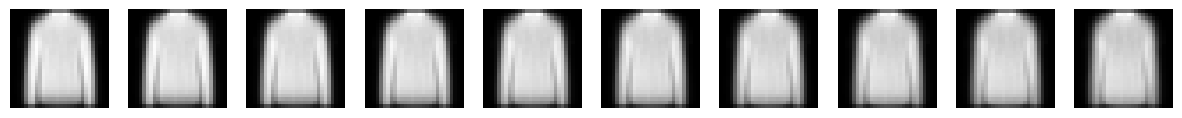

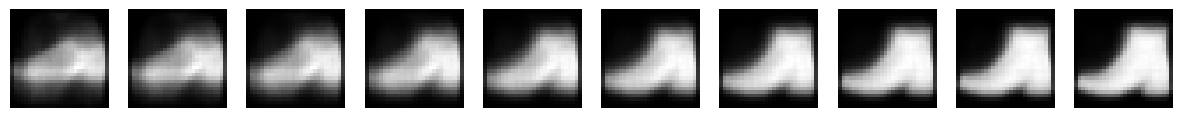

In [32]:
#calculo de vectores prototípicos
total_mu = total_mu.to(device_gpu)
total_labels = total_labels.to(device_gpu)

prototypes = []
for i in range(10): # Hay 10 clases en Fashion-MNIST
   mask = (total_labels == i) #"En que posiciones de la lista está la clase 'i'?"
   vectores_de_esa_clase = total_mu[mask] #Cogemos solo los vectores 'mu' que cumplen la máscara

   prot = torch.mean(vectores_de_esa_clase, dim=0)
   prototypes.append(prot)

prototypes = torch.stack(prototypes)


#funcion para interpolar y visualizar
def interpolacion(model, class_a, class_b, steps=10):
    vec_a = prototypes[class_a]
    vec_b = prototypes[class_b]

    plt.figure(figsize=(15, 4))

    with torch.no_grad():
      for i in range(steps):
        t = i / (steps-1) # t es el porcentaje de mezcla
        z_mezcla = (1-t) * vec_a + t*vec_b # Si t=0, queda todo A. Si t=1, queda todo B. En medio, mezcla.
        img_mezcla = model.decode(z_mezcla)

        img_mezcla = img_mezcla.view(28, 28)
        plt.subplot(1, steps, i+1)
        plt.imshow(img_mezcla.cpu(), cmap='gray')
        plt.axis('off')

interpolacion(model, 7, 9) #Interpolar la clase 7 (Zapatillas) a la clase 9 (Bota)
interpolacion(model, 0, 2) #Interpolar la clase  0 (camiseta/top) a la clase 2 (Jersey)
interpolacion(model, 3, 1) #Interpolar la clase 3 (Vestido) a la clase 1 (Pantalón)
interpolacion(model, 8, 9) #Interpolar la clase 8 (Bolso) a la clase  9 (Bota)
interpolacion(model, 4, 6) #Interpolar la clase 4 (Abrigo) a la 6 (Camisa)
interpolacion(model, 5, 9) #Interpolar la clase clase 5 (Sandalia) a la clase 9 (Bota)